# Handling neutral classification data from Indeed

### Context

*Indeed* reviews contain a "content" section with sentences that have not been explicitly labeled by their author as pros or cons.

We refer to these unlabeled reviews as "neutral." They make up our neutral classification data — the portion of our datasets that *lacks* gold labels.

### What this program does

For each company, we segment these unlabeled/neutral reviews into Pandas dataframes by their authorship dates — that is, whether the review was posted *before* a date that has been identified in our timeline, or after.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
from dateutil.relativedelta import relativedelta
import math
from IPython.core.pylabtools import figsize

In [4]:
# Removing trailing whitespace from sentences (unneeded newlines, single-spaces, etc.)
def remove_whitespace_from(review_sentences):
  stripped_sentences = []
  for sentence in review_sentences:
    stripped_sentence = sentence.rstrip()
    stripped_sentences.append(stripped_sentence)
  return stripped_sentences

In [5]:
category_delimiter = "[LISTSEP]"

# Begin by finding, and keeping track of, the category separation indices;
# AKA, the indices in each file (of reviews/dates) at which
# the previous category ends and the next category begins.

# Input:
#   (1) list of review sentences
#   (2) list of corresponding dates
def get_sep_indices(list1, list2):
  
  end_indices = []
  for i in range(len(list1)):
    if list1[i] == category_delimiter and list2[i] == category_delimiter:
      end_indices.append(i)
  
  start_indices = [0]
  for j in range(len(end_indices)-1):
    start_indices.append(end_indices[j]+1)
  
  final_indices = []
  for k in range(len(start_indices)):
    final_indices.append((start_indices[k], end_indices[k]))
  
  return final_indices

In [6]:
# Input: 
#     (1) List of review sentences (AKA features)
#     (2) List of corresponding authorship dates
#     (3) Number of the category that we want to create a DF from (1-6)
#     (4) List of index tuples, indicating when categories begin and end
# Output: Pandas DF
def create_category_df(features, dates, category_num, category_indices):

  # USER INPUT VALIDATION
  # First, verify if there are as many review sentences as there are
  # corresponding dates.
  # If this is the case, then we should be ready to proceed.

  if len(features) != len(dates):
    print("ERROR: Mismatch detected in review sentences and authorship dates.\nPlease check your input and try again.")
    return

  else:

    features_column = []
    dates_column = []
    start_idx = category_indices[category_num-1][0]
    end_idx = category_indices[category_num-1][1]

    for i in range(start_idx, end_idx):
      features_column.append(features[i])
      dates_column.append(dates[i])
    
    dictionary = {'features': features_column, 'dates': dates_column}
    return pd.DataFrame(dictionary)

## Porting in valence text files - predictions generated by our fine-tuned BERT Classifier

In [7]:
def create_all_category_dfs(f_name):

  category_dfs = []
  delimiter = "[LISTSEP]\n"
  
  f_read = open(f_name, 'r')
  lines = f_read.readlines()
  f_read.close()

  dates_col = []
  sentiment_counts_col = []
  review_counts_col = []
  
  for line in lines:

    if line == delimiter:
      # Create dictionary from columns — then dataframe from dictionary
      dictionary = {'dates': dates_col, 'sentiment_count': sentiment_counts_col, 'num_reviews': review_counts_col}
      df = pd.DataFrame(dictionary)
      df.set_index('dates', inplace=True, drop=True)
      category_dfs.append(df)
      # Reset columns
      dates_col = []
      sentiment_counts_col = []
      review_counts_col = []
    
    else:
      # Parse contents from line
      split_components = line.split(':')
      month = split_components[0].split('/')[0]
      year = split_components[0].split('/')[1]
      num_pros = int(split_components[1].split('|')[0])
      num_cons = int(split_components[1].split('|')[1])
      # Continue building up columns for this category
      date_string = month + "/01/" + year
      timestamp = datetime.strptime(date_string, "%m/%d/%Y")
      dates_col.append(timestamp)
      sentiment_counts_col.append(num_pros - num_cons)
      review_counts_col.append(num_pros + num_cons)
  
  return category_dfs

In [8]:
riot_category_dfs = create_all_category_dfs('/content/drive/MyDrive/compling_final/IndeedBERT/riotIndeedValences.txt')
sony_category_dfs = create_all_category_dfs('/content/drive/MyDrive/compling_final/IndeedBERT/sonyIndeedValences.txt')
ubisoft_category_dfs = create_all_category_dfs('/content/drive/MyDrive/compling_final/IndeedBERT/ubisoftIndeedValences.txt')
activision_category_dfs = create_all_category_dfs('/content/drive/MyDrive/compling_final/IndeedBERT/activisionIndeedValences.txt')

# Using matplotlib to plot sentiment scores per company & per category across timeline

In [9]:
# Riot reviews

riot_pros_f1 = open("/content/drive/MyDrive/compling_final/Glassdoor/riotProsClassified.txt", 'r')
riot_pos_1 = remove_whitespace_from(riot_pros_f1.readlines())

riot_cons_f1 = open("/content/drive/MyDrive/compling_final/Glassdoor/riotConsClassified.txt", 'r')
riot_neg_1 = remove_whitespace_from(riot_cons_f1.readlines())

riot_pros_f2 = open("/content/drive/MyDrive/compling_final/Indeed/riotProsIndeedClassified.txt", 'r')
riot_pos_2 = remove_whitespace_from(riot_pros_f2.readlines())

riot_cons_f2 = open("/content/drive/MyDrive/compling_final/Indeed/riotConsIndeedClassified.txt", 'r')
riot_neg_2 = remove_whitespace_from(riot_cons_f2.readlines())

In [10]:
# Riot dates

riot_pros_dates_f1 = open("/content/drive/MyDrive/compling_final/Glassdoor/dates/riotPosDates.txt", "r")
riot_pos_dates_1 = remove_whitespace_from(riot_pros_dates_f1.readlines())

riot_cons_dates_f1 = open("/content/drive/MyDrive/compling_final/Glassdoor/dates/riotNegDates.txt", "r")
riot_neg_dates_1 = remove_whitespace_from(riot_cons_dates_f1.readlines())

riot_pros_dates_f2 = open("/content/drive/MyDrive/compling_final/Indeed/dates/riotProsIndeedDates.txt", "r")
riot_pos_dates_2 = remove_whitespace_from(riot_pros_dates_f2.readlines())

riot_cons_dates_f2 = open("/content/drive/MyDrive/compling_final/Indeed/dates/riotConsIndeedDates.txt", "r")
riot_neg_dates_2 = remove_whitespace_from(riot_cons_dates_f2.readlines())

In [11]:
# Sony reviews

sony_pros_f1 = open("/content/drive/MyDrive/compling_final/Glassdoor/sonyProsClassified.txt", 'r')
sony_pos_1 = remove_whitespace_from(sony_pros_f1.readlines())

sony_cons_f1 = open("/content/drive/MyDrive/compling_final/Glassdoor/sonyConsClassified.txt", 'r')
sony_neg_1 = remove_whitespace_from(sony_cons_f1.readlines())

sony_pros_f2 = open("/content/drive/MyDrive/compling_final/Indeed/sonyProsIndeedClassified.txt", 'r')
sony_pos_2 = remove_whitespace_from(sony_pros_f2.readlines())

sony_cons_f2 = open("/content/drive/MyDrive/compling_final/Indeed/sonyConsIndeedClassified.txt", 'r')
sony_neg_2 = remove_whitespace_from(sony_cons_f2.readlines())

In [12]:
# Sony dates

sony_pros_dates_f1 = open("/content/drive/MyDrive/compling_final/Glassdoor/dates/sonyPosDates.txt", "r")
sony_pos_dates_1 = remove_whitespace_from(sony_pros_dates_f1.readlines())

sony_cons_dates_f1 = open("/content/drive/MyDrive/compling_final/Glassdoor/dates/sonyNegDates.txt", "r")
sony_neg_dates_1 = remove_whitespace_from(sony_cons_dates_f1.readlines())

sony_pros_dates_f2 = open("/content/drive/MyDrive/compling_final/Indeed/dates/sonyProsIndeedDates.txt", "r")
sony_pos_dates_2 = remove_whitespace_from(sony_pros_dates_f2.readlines())

sony_cons_dates_f2 = open("/content/drive/MyDrive/compling_final/Indeed/dates/sonyConsIndeedDates.txt", "r")
sony_neg_dates_2 = remove_whitespace_from(sony_cons_dates_f2.readlines())

In [13]:
# Ubisoft reviews

ubisoft_pros_f1 = open("/content/drive/MyDrive/compling_final/Glassdoor/ubisoftProsClassified.txt", 'r')
ubisoft_pos_1 = remove_whitespace_from(ubisoft_pros_f1.readlines())

ubisoft_cons_f1 = open("/content/drive/MyDrive/compling_final/Glassdoor/ubisoftConsClassified.txt", 'r')
ubisoft_neg_1 = remove_whitespace_from(ubisoft_cons_f1.readlines())

ubisoft_pros_f2 = open("/content/drive/MyDrive/compling_final/Indeed/ubisoftProsIndeedClassified.txt", 'r')
ubisoft_pos_2 = remove_whitespace_from(ubisoft_pros_f2.readlines())

ubisoft_cons_f2 = open("/content/drive/MyDrive/compling_final/Indeed/ubisoftConsIndeedClassified.txt", 'r')
ubisoft_neg_2 = remove_whitespace_from(ubisoft_cons_f2.readlines())

In [14]:
# Ubisoft dates

ubisoft_pros_dates_f1 = open("/content/drive/MyDrive/compling_final/Glassdoor/dates/ubisoftPosDates.txt", "r")
ubisoft_pos_dates_1 = remove_whitespace_from(ubisoft_pros_dates_f1.readlines())

ubisoft_cons_dates_f1 = open("/content/drive/MyDrive/compling_final/Glassdoor/dates/ubisoftNegDates.txt", "r")
ubisoft_neg_dates_1 = remove_whitespace_from(ubisoft_cons_dates_f1.readlines())

ubisoft_pros_dates_f2 = open("/content/drive/MyDrive/compling_final/Indeed/dates/ubisoftProsIndeedDates.txt", "r")
ubisoft_pos_dates_2 = remove_whitespace_from(ubisoft_pros_dates_f2.readlines())

ubisoft_cons_dates_f2 = open("/content/drive/MyDrive/compling_final/Indeed/dates/ubisoftConsIndeedDates.txt", "r")
ubisoft_neg_dates_2 = remove_whitespace_from(ubisoft_cons_dates_f2.readlines())

In [15]:
# Activision reviews

activision_pros_f1 = open("/content/drive/MyDrive/compling_final/Glassdoor/activisionProsClassified.txt", 'r')
activision_pos_1 = remove_whitespace_from(activision_pros_f1.readlines())

activision_cons_f1 = open("/content/drive/MyDrive/compling_final/Glassdoor/activisionConsClassified.txt", 'r')
activision_neg_1 = remove_whitespace_from(activision_cons_f1.readlines())

activision_pros_f2 = open("/content/drive/MyDrive/compling_final/Indeed/activisionProsIndeedClassified.txt", 'r')
activision_pos_2 = remove_whitespace_from(activision_pros_f2.readlines())

activision_cons_f2 = open("/content/drive/MyDrive/compling_final/Indeed/activisionConsIndeedClassified.txt", 'r')
activision_neg_2 = remove_whitespace_from(activision_cons_f2.readlines())

In [16]:
# Activision dates

activision_pros_dates_f1 = open("/content/drive/MyDrive/compling_final/Glassdoor/dates/activisionPosDates.txt", "r")
activision_pos_dates_1 = remove_whitespace_from(activision_pros_dates_f1.readlines())

activision_cons_dates_f1 = open("/content/drive/MyDrive/compling_final/Glassdoor/dates/activisionNegDates.txt", "r")
activision_neg_dates_1 = remove_whitespace_from(activision_cons_dates_f1.readlines())

activision_pros_dates_f2 = open("/content/drive/MyDrive/compling_final/Indeed/dates/activisionProsIndeedDates.txt", "r")
activision_pos_dates_2 = remove_whitespace_from(activision_pros_dates_f2.readlines())

activision_cons_dates_f2 = open("/content/drive/MyDrive/compling_final/Indeed/dates/activisionConsIndeedDates.txt", "r")
activision_neg_dates_2 = remove_whitespace_from(activision_cons_dates_f2.readlines())

## Generating a combined DataFrame for Glassdoor & Indeed pros, cons

When we are working with gold-label classification features, there is no purpose to distinguishing between the *source* of the review. Whether the review was scraped from Glassdoor or Indeed matters not. This distinction is only relevant for handling unlabeled/"neutral" classification features.

In [17]:
def create_combined_category_df(features1, features2, dates1, dates2, category_num):
  category_indices_1 = get_sep_indices(features1, dates1)
  category_indices_2 = get_sep_indices(features2, dates2)
  df1 = create_category_df(features1, dates1, category_num, category_indices_1)
  df2 = create_category_df(features2, dates2, category_num, category_indices_2)
  
  # Concatenate dataframes
  return pd.concat([df1, df2])

In [18]:
# RIOT GAMES: Pros from both Glassdoor & Indeed

riot_pros_df_1 = create_combined_category_df(riot_pos_1, riot_pos_2, riot_pos_dates_1, riot_pos_dates_2, 1)
riot_pros_df_2 = create_combined_category_df(riot_pos_1, riot_pos_2, riot_pos_dates_1, riot_pos_dates_2, 2)
riot_pros_df_3 = create_combined_category_df(riot_pos_1, riot_pos_2, riot_pos_dates_1, riot_pos_dates_2, 3)
riot_pros_df_4 = create_combined_category_df(riot_pos_1, riot_pos_2, riot_pos_dates_1, riot_pos_dates_2, 4)
riot_pros_df_5 = create_combined_category_df(riot_pos_1, riot_pos_2, riot_pos_dates_1, riot_pos_dates_2, 5)
riot_pros_df_6 = create_combined_category_df(riot_pos_1, riot_pos_2, riot_pos_dates_1, riot_pos_dates_2, 6)

In [19]:
# RIOT GAMES: Cons from both Glassdoor & Indeed

riot_cons_df_1 = create_combined_category_df(riot_neg_1, riot_neg_2, riot_neg_dates_1, riot_neg_dates_2, 1)
riot_cons_df_2 = create_combined_category_df(riot_neg_1, riot_neg_2, riot_neg_dates_1, riot_neg_dates_2, 2)
riot_cons_df_3 = create_combined_category_df(riot_neg_1, riot_neg_2, riot_neg_dates_1, riot_neg_dates_2, 3)
riot_cons_df_4 = create_combined_category_df(riot_neg_1, riot_neg_2, riot_neg_dates_1, riot_neg_dates_2, 4)
riot_cons_df_5 = create_combined_category_df(riot_neg_1, riot_neg_2, riot_neg_dates_1, riot_neg_dates_2, 5)
riot_cons_df_6 = create_combined_category_df(riot_neg_1, riot_neg_2, riot_neg_dates_1, riot_neg_dates_2, 6)

In [20]:
# SONY: Pros from both Glassdoor & Indeed

sony_pros_df_1 = create_combined_category_df(sony_pos_1, sony_pos_2, sony_pos_dates_1, sony_pos_dates_2, 1)
sony_pros_df_2 = create_combined_category_df(sony_pos_1, sony_pos_2, sony_pos_dates_1, sony_pos_dates_2, 2)
sony_pros_df_3 = create_combined_category_df(sony_pos_1, sony_pos_2, sony_pos_dates_1, sony_pos_dates_2, 3)
sony_pros_df_4 = create_combined_category_df(sony_pos_1, sony_pos_2, sony_pos_dates_1, sony_pos_dates_2, 4)
sony_pros_df_5 = create_combined_category_df(sony_pos_1, sony_pos_2, sony_pos_dates_1, sony_pos_dates_2, 5)
sony_pros_df_6 = create_combined_category_df(sony_pos_1, sony_pos_2, sony_pos_dates_1, sony_pos_dates_2, 6)

In [21]:
# SONY: Cons from both Glassdoor & Indeed

sony_cons_df_1 = create_combined_category_df(sony_neg_1, sony_neg_2, sony_neg_dates_1, sony_neg_dates_2, 1)
sony_cons_df_2 = create_combined_category_df(sony_neg_1, sony_neg_2, sony_neg_dates_1, sony_neg_dates_2, 2)
sony_cons_df_3 = create_combined_category_df(sony_neg_1, sony_neg_2, sony_neg_dates_1, sony_neg_dates_2, 3)
sony_cons_df_4 = create_combined_category_df(sony_neg_1, sony_neg_2, sony_neg_dates_1, sony_neg_dates_2, 4)
sony_cons_df_5 = create_combined_category_df(sony_neg_1, sony_neg_2, sony_neg_dates_1, sony_neg_dates_2, 5)
sony_cons_df_6 = create_combined_category_df(sony_neg_1, sony_neg_2, sony_neg_dates_1, sony_neg_dates_2, 6)

In [22]:
# UBISOFT: Pros from both Glassdoor & Indeed

ubisoft_pros_df_1 = create_combined_category_df(ubisoft_pos_1, ubisoft_pos_2, ubisoft_pos_dates_1, ubisoft_pos_dates_2, 1)
ubisoft_pros_df_2 = create_combined_category_df(ubisoft_pos_1, ubisoft_pos_2, ubisoft_pos_dates_1, ubisoft_pos_dates_2, 2)
ubisoft_pros_df_3 = create_combined_category_df(ubisoft_pos_1, ubisoft_pos_2, ubisoft_pos_dates_1, ubisoft_pos_dates_2, 3)
ubisoft_pros_df_4 = create_combined_category_df(ubisoft_pos_1, ubisoft_pos_2, ubisoft_pos_dates_1, ubisoft_pos_dates_2, 4)
ubisoft_pros_df_5 = create_combined_category_df(ubisoft_pos_1, ubisoft_pos_2, ubisoft_pos_dates_1, ubisoft_pos_dates_2, 5)
ubisoft_pros_df_6 = create_combined_category_df(ubisoft_pos_1, ubisoft_pos_2, ubisoft_pos_dates_1, ubisoft_pos_dates_2, 6)

In [23]:
# UBISOFT: Cons from both Glassdoor & Indeed

ubisoft_cons_df_1 = create_combined_category_df(ubisoft_neg_1, ubisoft_neg_2, ubisoft_neg_dates_1, ubisoft_neg_dates_2, 1)
ubisoft_cons_df_2 = create_combined_category_df(ubisoft_neg_1, ubisoft_neg_2, ubisoft_neg_dates_1, ubisoft_neg_dates_2, 2)
ubisoft_cons_df_3 = create_combined_category_df(ubisoft_neg_1, ubisoft_neg_2, ubisoft_neg_dates_1, ubisoft_neg_dates_2, 3)
ubisoft_cons_df_4 = create_combined_category_df(ubisoft_neg_1, ubisoft_neg_2, ubisoft_neg_dates_1, ubisoft_neg_dates_2, 4)
ubisoft_cons_df_5 = create_combined_category_df(ubisoft_neg_1, ubisoft_neg_2, ubisoft_neg_dates_1, ubisoft_neg_dates_2, 5)
ubisoft_cons_df_6 = create_combined_category_df(ubisoft_neg_1, ubisoft_neg_2, ubisoft_neg_dates_1, ubisoft_neg_dates_2, 6)

In [24]:
# ACTIVISION: Pros from both Glassdoor & Indeed

activision_pros_df_1 = create_combined_category_df(activision_pos_1, activision_pos_2, activision_pos_dates_1, activision_pos_dates_2, 1)
activision_pros_df_2 = create_combined_category_df(activision_pos_1, activision_pos_2, activision_pos_dates_1, activision_pos_dates_2, 2)
activision_pros_df_3 = create_combined_category_df(activision_pos_1, activision_pos_2, activision_pos_dates_1, activision_pos_dates_2, 3)
activision_pros_df_4 = create_combined_category_df(activision_pos_1, activision_pos_2, activision_pos_dates_1, activision_pos_dates_2, 4)
activision_pros_df_5 = create_combined_category_df(activision_pos_1, activision_pos_2, activision_pos_dates_1, activision_pos_dates_2, 5)
activision_pros_df_6 = create_combined_category_df(activision_pos_1, activision_pos_2, activision_pos_dates_1, activision_pos_dates_2, 6)

In [25]:
# ACTIVISION: Cons from both Glassdoor & Indeed

activision_cons_df_1 = create_combined_category_df(activision_neg_1, activision_neg_2, activision_neg_dates_1, activision_neg_dates_2, 1)
activision_cons_df_2 = create_combined_category_df(activision_neg_1, activision_neg_2, activision_neg_dates_1, activision_neg_dates_2, 2)
activision_cons_df_3 = create_combined_category_df(activision_neg_1, activision_neg_2, activision_neg_dates_1, activision_neg_dates_2, 3)
activision_cons_df_4 = create_combined_category_df(activision_neg_1, activision_neg_2, activision_neg_dates_1, activision_neg_dates_2, 4)
activision_cons_df_5 = create_combined_category_df(activision_neg_1, activision_neg_2, activision_neg_dates_1, activision_neg_dates_2, 5)
activision_cons_df_6 = create_combined_category_df(activision_neg_1, activision_neg_2, activision_neg_dates_1, activision_neg_dates_2, 6)

https://matplotlib.org/stable/gallery/lines_bars_and_markers/timeline.html

In [26]:
# Per-category
def generate_net_sentiment_counts_df(df_pros, df_cons):

  # pros
  dates_pros = [datetime.strptime(d, "%m/%d/%Y") for d in df_pros['dates']]
  df_dates_pros = pd.DataFrame({'pros_counts': dates_pros})
  sorted_dates_pros = df_dates_pros['pros_counts'].value_counts().sort_index()

  # cons
  dates_cons = [datetime.strptime(d, "%m/%d/%Y") for d in df_cons['dates']]
  df_dates_cons = pd.DataFrame({'cons_counts': dates_cons})
  sorted_dates_cons = df_dates_cons['cons_counts'].value_counts().sort_index()

  combined_dates = pd.concat([sorted_dates_pros, sorted_dates_cons], axis=1)

  dates_col = []
  sentiment_count_col = []
  review_count_col = []
  
  for index, row in combined_dates.iterrows():
    pro_count = 0.0 if math.isnan(row['pros_counts']) else row['pros_counts']
    con_count = 0.0 if math.isnan(row['cons_counts']) else row['cons_counts']

    sentiment_count = pro_count - con_count
    num_reviews = pro_count + con_count

    dates_col.append(index)
    sentiment_count_col.append(sentiment_count)
    review_count_col.append(num_reviews)

  dictionary = {'dates': dates_col, 'sentiment_count': sentiment_count_col, 'num_reviews': review_count_col}
  df = pd.DataFrame(dictionary)

  # Sort the merged DF, again, by date
  df_sorted = df.sort_values(by='dates')

  # Set the 'dates' column, with its datetime values, as the DF's index
  # Referenced this:
  # https://stackoverflow.com/questions/42196337/dataframe-set-index-not-setting 
  df_sorted.set_index('dates', inplace=True, drop=True)

  return df_sorted

In [27]:
riot_counts_df_1 = generate_net_sentiment_counts_df(riot_pros_df_1, riot_cons_df_1)
riot_counts_df_2 = generate_net_sentiment_counts_df(riot_pros_df_2, riot_cons_df_2)
riot_counts_df_3 = generate_net_sentiment_counts_df(riot_pros_df_3, riot_cons_df_3)
riot_counts_df_4 = generate_net_sentiment_counts_df(riot_pros_df_4, riot_cons_df_4)
riot_counts_df_5 = generate_net_sentiment_counts_df(riot_pros_df_5, riot_cons_df_5)
riot_counts_df_6 = generate_net_sentiment_counts_df(riot_pros_df_6, riot_cons_df_6)

In [28]:
sony_counts_df_1 = generate_net_sentiment_counts_df(sony_pros_df_1, sony_cons_df_1)
sony_counts_df_2 = generate_net_sentiment_counts_df(sony_pros_df_2, sony_cons_df_2)
sony_counts_df_3 = generate_net_sentiment_counts_df(sony_pros_df_3, sony_cons_df_3)
sony_counts_df_4 = generate_net_sentiment_counts_df(sony_pros_df_4, sony_cons_df_4)
sony_counts_df_5 = generate_net_sentiment_counts_df(sony_pros_df_5, sony_cons_df_5)
sony_counts_df_6 = generate_net_sentiment_counts_df(sony_pros_df_6, sony_cons_df_6)

In [29]:
ubisoft_counts_df_1 = generate_net_sentiment_counts_df(ubisoft_pros_df_1, ubisoft_cons_df_1)
ubisoft_counts_df_2 = generate_net_sentiment_counts_df(ubisoft_pros_df_2, ubisoft_cons_df_2)
ubisoft_counts_df_3 = generate_net_sentiment_counts_df(ubisoft_pros_df_3, ubisoft_cons_df_3)
ubisoft_counts_df_4 = generate_net_sentiment_counts_df(ubisoft_pros_df_4, ubisoft_cons_df_4)
ubisoft_counts_df_5 = generate_net_sentiment_counts_df(ubisoft_pros_df_5, ubisoft_cons_df_5)
ubisoft_counts_df_6 = generate_net_sentiment_counts_df(ubisoft_pros_df_6, ubisoft_cons_df_6)

In [64]:
activision_counts_df_1 = generate_net_sentiment_counts_df(activision_pros_df_1, activision_cons_df_1)
activision_counts_df_2 = generate_net_sentiment_counts_df(activision_pros_df_2, activision_cons_df_2)
activision_counts_df_3 = generate_net_sentiment_counts_df(activision_pros_df_3, activision_cons_df_3)
activision_counts_df_4 = generate_net_sentiment_counts_df(activision_pros_df_4, activision_cons_df_4)
activision_counts_df_5 = generate_net_sentiment_counts_df(activision_pros_df_5, activision_cons_df_5)
activision_counts_df_6 = generate_net_sentiment_counts_df(activision_pros_df_6, activision_cons_df_6)

# Plotting evilly

Lightly referenced the following resources for matplotlib setup:

*   https://matplotlib.org/stable/gallery/lines_bars_and_markers/timeline.html
*   https://nbviewer.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb



In [75]:
# Generates a "trimmed" bar graph with a superimposed plotted line,
# wherein x = time (across years), and y = measurement of sentiment.
# The bar graph pictorially represents the 'sentiment counts' across a
# stretch of years, where said count is determined by
# (the number of features labeled as pros that were authored in a timespan)
# - (the number of features labeled as cons that were authored in that same timespan).
# The plotted line pictorially represents a 'sentiment average':
# the sentiment count (just described), divided by
# the overall number of features authored in that timespan
# (in other words, number of pros + number of cons).

# (for the lower limit of the x-axis)
# We don't trim the upper limit of the x-axis because we specifically chose
# to focus on companies that were *recently* hit with lawsuits, etc.
# So it is relevant to us how sentiment has changed since those events,
# which are recently occurring,
# by nature of our experiment.

# Input:
#     (1) Time-series dataset, where x = time and y = sentiment measurement,
#             as a Pandas DF;
#     (2) The dates of significant events (in MM/DD/YYYY format), as strings;
#     (3) Annotated labels for these dates, as strings;
#     (4) Intended title of the plot.
# Output:
#     Timeline.
def plot_histogram_trimmed(df, events, labels, category_title):

  figsize(12.5, 5)

  plt.title("Sentiment measurements over time (" + category_title + ")")
  plt.xlabel("Time (years)")
  plt.ylabel("Sentiment")

  # Setting x-axis lower/upper limits:
  # Trimming the timeline by setting a more 'recent' x lower limit
  first_event_date = datetime.strptime(events[0], "%m/%d/%Y")
  first_event_x_idx = np.argmin(np.abs(df.index.to_pydatetime() - first_event_date))
  x_lower_lim = first_event_x_idx - (len(df.index)/first_event_x_idx)
  # However, we shouldn't be using this for the lower limit if the first event date
  # does not precede the first authorship date for reviews in this category.
  if x_lower_lim < 0:
    x_lower_lim = 0
  x_upper_lim = len(df.index)
  plt.xlim(x_lower_lim, x_upper_lim)

  # Setting y-axis lower/upper limits
  # Select rows by index labels
  rows_df = df.loc[df.index[math.floor(x_lower_lim)]:df.index[-1]]
  y_upper_lim = rows_df['sentiment_count'].max() + 0.5
  y_lower_lim = rows_df['sentiment_count'].min() - 0.5
  plt.ylim(y_lower_lim, y_upper_lim)

  # Internal frame color - light grey
  ax = plt.gca()
  ax.set_facecolor('#f5f5f5')

  # Borders/spines - dotted line style, dark grey
  ax.spines['bottom'].set_linestyle('dashed')
  ax.spines['bottom'].set_edgecolor('#707070')
  ax.spines['top'].set_linestyle('dashed')
  ax.spines['top'].set_edgecolor('#707070')
  ax.spines['left'].set_linestyle('dashed')
  ax.spines['left'].set_edgecolor('#707070')
  ax.spines['right'].set_linestyle('dashed')
  ax.spines['right'].set_edgecolor('#707070')

  # PLOTTED LINE
  
  # Generate average sentiment metric, which is (#pros-#cons)/(#totalreviews)
  avg_sentiment = []
  for index, row in df.iterrows():
    avg_sentiment.append(row['sentiment_count'] / row['num_reviews'])
  plt.plot(range(len(df.index)), avg_sentiment, lw=3, color="#0062FF",
           label="average sentiment")
  
  # BAR GRAPH

  # Color the bars that go into the positives, green
  # Color the bars that go in the negatives, red
  color_map = np.where(df['sentiment_count'] > 0, '#70E1A6', '#ff8282')
  plt.bar(np.arange(len(df.index)), df['sentiment_count'], color=color_map, alpha=0.65,
          label="sentiment count (#pros-#cons)")

  # Horizontal line at y = 0
  # For delineating between positive & negative sentiment measurements
  plt.hlines(0, xmin=0, xmax=len(df.index), color='k', linestyle=':', lw=1)

  # Vertical lines - dates of significant events
  for idx in range(len(events)):
    
    event = events[idx]
    event_date = datetime.strptime(event, "%m/%d/%Y")
    
    if (event_date < df.index[-1]):
      
      i = np.argmin(np.abs(df.index.to_pydatetime() - event_date))
      
      # Given event_date as the x_intersect, calculate the y_intersect
      # using linear interpolation
      x0 = 0
      y0 = 0
      x1 = 0
      y1 = 0
      
      if df.index[i] < event_date:
        x0 = i                                    # timestamp (before event)
        y0 = (df.iloc[i][0] / df.iloc[i][1])      # sentiment (before event)
        x1 = i+1                                  # timestamp (after event)
        y1 = (df.iloc[i+1][0] / df.iloc[i+1][1])  # sentiment (after event)
      else:
        x0 = i-1                                  # timestamp (before event)
        y0 = (df.iloc[i-1][0] / df.iloc[i-1][1])  # sentiment (before event)
        x1 = i                                    # timestamp (after event)
        y1 = (df.iloc[i][0] / df.iloc[i][1])      # sentiment (after event)

      time_difference = event_date - df.index[x0].to_pydatetime()
      time_bin = df.index[x1] - df.index[x0]
      x_intercept = (time_difference / time_bin) + x0
      y_intercept = (y0 * (x1 - x_intercept) + y1 * (x_intercept - x0)) / (x1 - x0)
      y_max = 0
      
      if y_intercept > 0:       # Positive - draw line trailing upward, green
        plt.vlines(x = x_intercept, ymin = y_intercept, ymax = y_upper_lim-0.1, color='#4CC6FF')
        label = labels[idx]
        ax.annotate(label, xy=(x_intercept+0.1, y_upper_lim), rotation=90, color='#225CB7',
                    horizontalalignment='right', verticalalignment='top', fontsize=9)
     
      else:                     # Negative - draw line trailing downward
        plt.vlines(x = x_intercept, ymin = y_intercept, ymax = y_lower_lim+0.1, color='#4CC6FF')
        label = labels[idx]
        ax.annotate(label, xy=(x_intercept+0.1, y_lower_lim), rotation=90, color='#225CB7',
                    horizontalalignment='right', verticalalignment='bottom', fontsize=9)
      
      # Add marker @ x_intercept, y_intercept
      plt.plot(x_intercept, y_intercept, marker='o', markersize=7, fillstyle='full', markeredgecolor='k', markerfacecolor='w', alpha=0.9)

  # Add more coherent labels, in the form of years, to the x-axis

  # Determine which span of years we should use as labels
  first_year = int(first_event_date.year)
  last_year = int(df.index[-1].year)
  year_labels = []
  for year_i in range(first_year + 1, last_year + 1):
    year_labels.append(year_i)
  
  # Now find the appropriate x-values at which these year labels should be placed
  x_years = []
  for year_l in year_labels:
    # Just using the start of each year - the first day of the first month
    dt = datetime(year_l, 1, 1)
    dt_x = np.argmin(np.abs(df.index.to_pydatetime() - dt))
    x_years.append(dt_x)
  
  # Finally, set these year labels at their corresponding 'x_years' position in the x-axis
  plt.xticks(x_years, year_labels, rotation='horizontal')

  plt.legend(loc="upper left")
  plt.show()

In [102]:
# An attenuated version of 'plot_histogram_trimmed'
# that is used when none of the features belonging to a category were authored
# during the timespan covered by the company's events.

# Input:
#     (1) Time-series dataset, where x = time and y = sentiment measurement,
#             as a Pandas DF;
#     (2) Intended title of the plot.
# Output:
#     Timeline.
def plot_histogram_no_events(df, category_title):

  figsize(12.5, 5)

  plt.title("Sentiment measurements over time (" + category_title + ")")
  plt.xlabel("Time (years)")
  plt.ylabel("Sentiment")

  # Internal frame color - light grey
  ax = plt.gca()
  ax.set_facecolor('#f5f5f5')

  # Borders/spines - dotted line style, dark grey
  ax.spines['bottom'].set_linestyle('dashed')
  ax.spines['bottom'].set_edgecolor('#707070')
  ax.spines['top'].set_linestyle('dashed')
  ax.spines['top'].set_edgecolor('#707070')
  ax.spines['left'].set_linestyle('dashed')
  ax.spines['left'].set_edgecolor('#707070')
  ax.spines['right'].set_linestyle('dashed')
  ax.spines['right'].set_edgecolor('#707070')

  # PLOTTED LINE
  
  # Generate average sentiment metric, which is (#pros-#cons)/(#totalreviews)
  avg_sentiment = []
  for index, row in df.iterrows():
    avg_sentiment.append(row['sentiment_count'] / row['num_reviews'])
  plt.plot(range(len(df.index)), avg_sentiment, lw=3, color="#0062FF",
           label="average sentiment")
  
  # BAR GRAPH

  # Color the bars that go into the positives, green
  # Color the bars that go in the negatives, red
  color_map = np.where(df['sentiment_count'] > 0, '#70E1A6', '#ff8282')
  plt.bar(np.arange(len(df.index)), df['sentiment_count'], color=color_map, alpha=0.65,
          label="sentiment count (#pros-#cons)")

  # Horizontal line at y = 0
  # For delineating between positive & negative sentiment measurements
  plt.hlines(0, xmin=0, xmax=len(df.index), color='k', linestyle=':', lw=1)

  # Labels
  x_coords = np.arange(len(df.index))
  x_labels = []
  for i in x_coords:
    label = str(df.index[i].to_pydatetime().month) + "/" + str(df.index[i].to_pydatetime().year)
    x_labels.append(label)
  
  if len(x_coords) > 10:
    # Only plot every other label as a tick on the x-axis
    # There are too many otherwise
    plt.xticks(x_coords[::2], x_labels[::2], rotation=30, fontsize=8)
  else:
    plt.xticks(x_coords, x_labels, rotation=30, fontsize=8)

  plt.legend(loc="upper left")
  plt.show()

In [86]:
category_titles = ["C1: Diversity & Inclusion", "C2: Culture & Values", "C3: Work-Life Balance", "C4: Senior Management", "C5: Career Opportunities", "C6: Compensation & Benefits"]

In [114]:
# Generates timelines for all 6 provided category dataframes for one company.
# Input:
#   (1) Pandas DFs (expected 6);
#   (2) The dates of significant events (in MM/DD/YYYY format), as strings;
#   (3) Annotated labels for these dates, as strings.
# Output:
#   Timelines, for categories that have MORE THAN ONE review assigned to them.
#   Just a print statement, for categories that only have ZERO/ONE review assigned to them.
def plot_all_categories(dfs, events, labels):
  for i in range(len(dfs)):
    category_df = dfs[i]
    # if i == 0:
    #   plot_histogram_no_events(category_df, category_titles[i])
    #   print("\n")
    # else:
    #   plot_histogram_trimmed(category_df, events, labels, category_titles[i])
    #   print("\n")
    if len(category_df.index) > 1:
      plot_histogram_trimmed(category_df, events, labels, category_titles[i])
      print("\n")
    else:
      print("There were no reviews classified in the category — " + category_titles[i] + "\n")

In [87]:
# A version of 'plot_all_categories' for accommodating features that were
# authored outside the scope of time spanned by a company's significant events.
# Calls 'plot_histogram_no_events' on DataFrames.
def plot_all_categories_no_events(dfs):
  for i in range(len(dfs)):
    category_df = dfs[i]
    if len(category_df.index) > 1:
      plot_histogram_no_events(category_df, category_titles[i])
      print("\n")
    else:
      print("There were no reviews classified in the category — " + category_titles[i] + "\n")

# Company 1: Riot Games

### Timeline:

*   **Oct. 16, 2017**: Riot Games' co-founders, Brandon Beck & Marc Merrill, step down from leadership to "be more hands-on with games."
*   **Aug. 7, 2018**: *Kotaku* publishes an exposé on sexism within Riot Games, containing personal accounts of over 28 former/current employees — what will eventually be recognized as the first of many public 'reveals' on Riot's "bro culture."
*   **Aug. 29, 2018**: Riot releases a public statement of apology. In it, the company outlines how it will go about addressing issues with its workplace culture: (1) expanding its D&I initiative, (2) "revisiting cultural definitions," (3) establishing a third-party evaluation system, & (4) "evaluating and improving [its] investigation process and systems."
*   **Dec. 13, 2018:** Chief Operating Officer Scott Gelb is placed on unpaid leave for two months, after several current/former Riot employees allege unprofessional, harassing, & abusive behavior. (Gelb presently remains with the company.)
*   **Feb. 26, 2019**: Riot releases an update on its D&I initatives, and agrees to workplace policy reforms, regarding: (1) greater transparency around pay, (2) not using prior salary history to set employees' pay, (3) creation of a pipeline for current/former temp agency contractors, & (4) implementation of a policy requiring a woman, or any other underrepresented person, to be on employment selection panels.
*   **Dec. 27, 2021**: Riot agrees to pay $100 million in the settlement of the class-action, gender-based discrimination lawsuit.

In [32]:
riot_event_timeline = ['10/16/2017', '08/07/2018', '08/29/2018', '12/13/2018', '2/26/2019', '12/27/2021']
riot_event_labels = ['Oct. 16, 2017', 'Aug. 7, 2018', 'Aug. 29, 2018', 'Dec. 13, 2018', 'Feb. 26, 2019', 'Dec. 27, 2021']

## Pt. 1: Plotting gold-label classification data over time

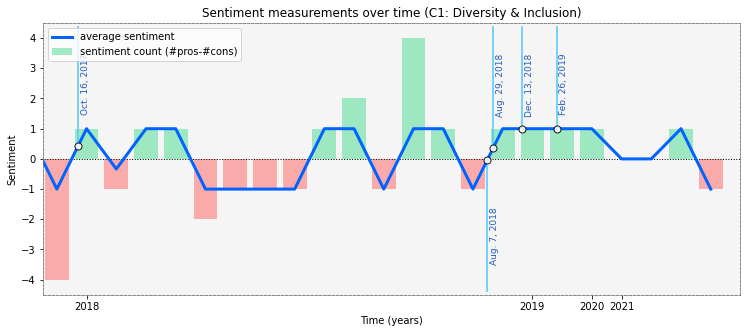

In [43]:
plot_histogram_trimmed(riot_counts_df_1, riot_event_timeline, riot_event_labels, "C1: Diversity & Inclusion")

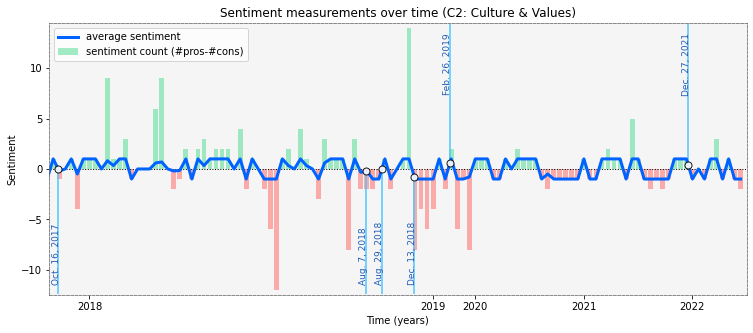

In [44]:
plot_histogram_trimmed(riot_counts_df_2, riot_event_timeline, riot_event_labels, "C2: Culture & Values")

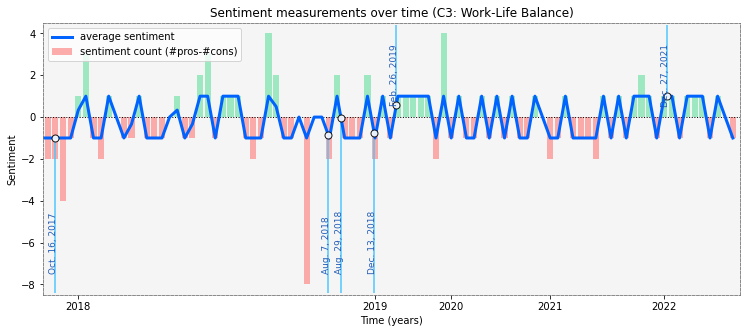

In [45]:
plot_histogram_trimmed(riot_counts_df_3, riot_event_timeline, riot_event_labels, "C3: Work-Life Balance")

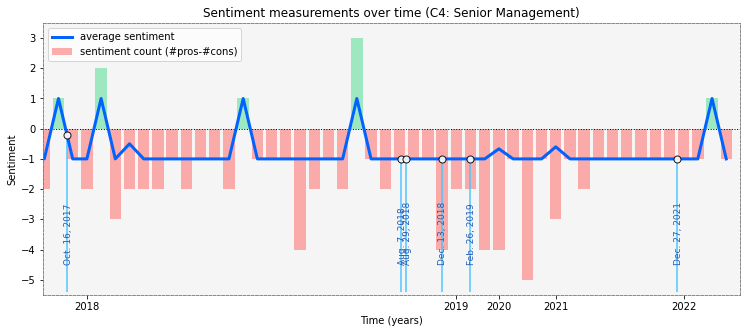

In [46]:
plot_histogram_trimmed(riot_counts_df_4, riot_event_timeline, riot_event_labels, "C4: Senior Management")

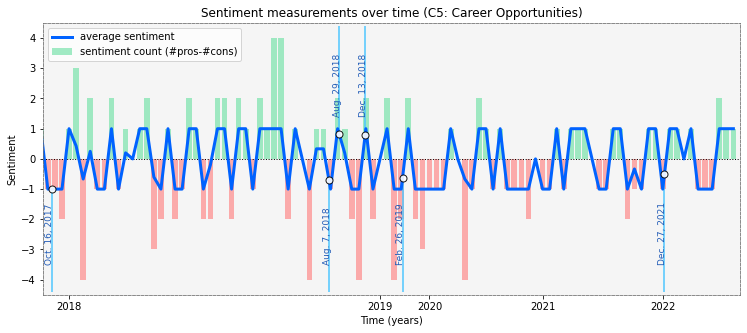

In [47]:
plot_histogram_trimmed(riot_counts_df_5, riot_event_timeline, riot_event_labels, "C5: Career Opportunities")

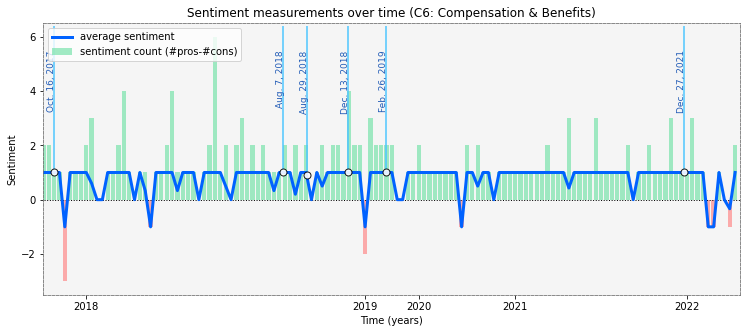

In [48]:
plot_histogram_trimmed(riot_counts_df_6, riot_event_timeline, riot_event_labels, "C6: Compensation & Benefits")

## Pt. 2: Plotting neutral classification data (generated via our fine-tuned BERT Classifier) over time

There were no reviews classified in the category — C1: Diversity & Inclusion



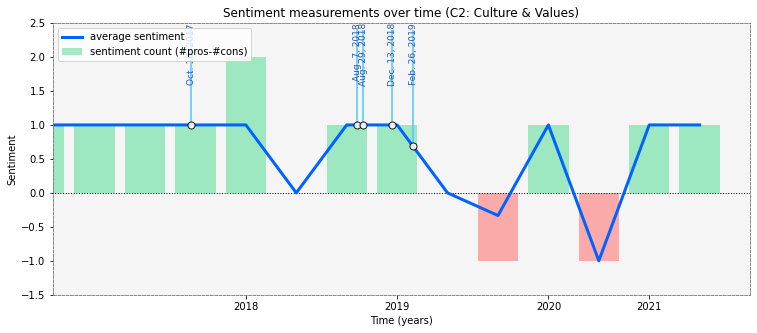

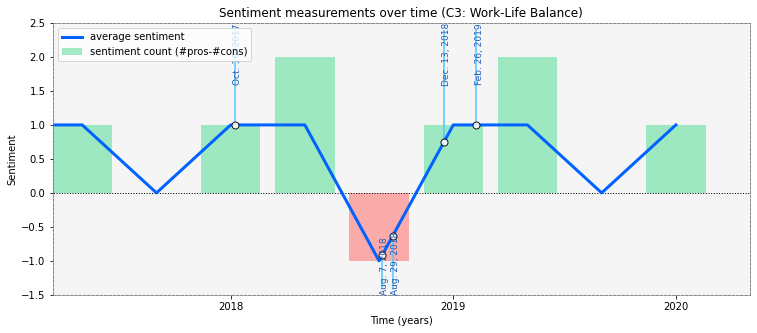



There were no reviews classified in the category — C4: Senior Management



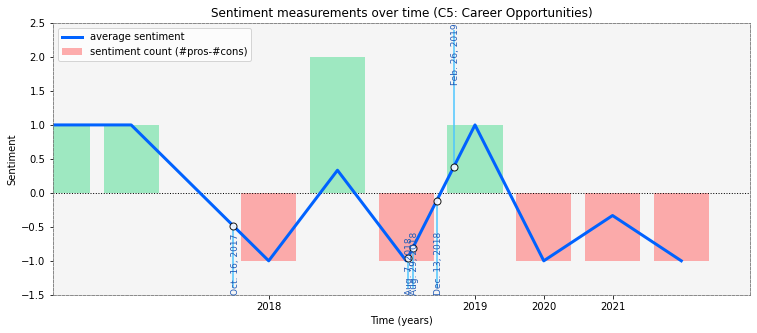

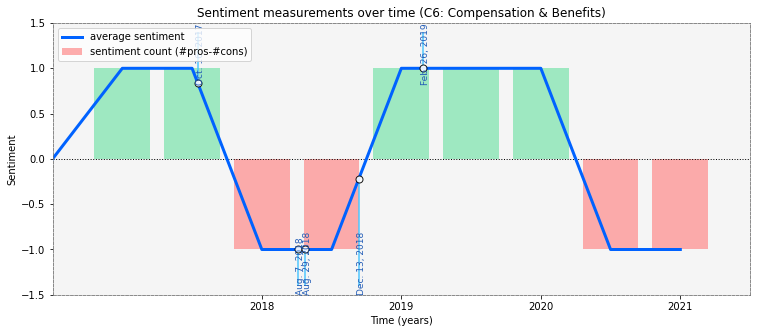

In [58]:
plot_all_categories(riot_category_dfs, riot_event_timeline, riot_event_labels)

# Company 2: Sony

### Timeline

*   **Nov. 22, 2021**: Former IT security analyst at Sony PlayStation, Emma Majo, sues the parent company Sony over gender-based harassment and gender-based discrimination.
*   **Feb. 22, 2022**: Sony asks the court to dismiss the class-action lawsuit, and denies all wrongdoing — pushing back against the lack of facts in Majo's federal complaint. 
*   **Apr. 22, 2022**: The federal judge in the case dismisses 10/13 of Majo's claims. She cites lack of evidence for some instanes, and miscategorization of harassment, regarding promotions and demotions, in others. She says that Majo may bring back the lawsuit if she supplies more specific details.
*   **May 23, 2022**: Majo sues Sony for a second time, narrowing her compaints from the federal to the state level. The second lawsuit compiles allegations from Majo's original Nov. complaint, as well as allegations that have come out since then from eight other female PlayStation employees (seven former, one current).

In [71]:
sony_event_timeline = ['11/22/2021', '02/22/2022', '04/22/2022', '05/23/2022']
sony_event_labels = ["Nov. 22, 2021", "Feb. 22, 2022", "Apr. 22, 2022", "May 23, 2022"]

## Pt. 1: Plotting gold-label classification data over time

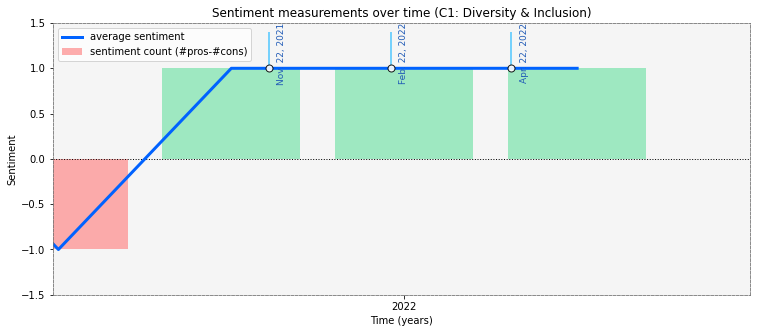

In [76]:
plot_histogram_trimmed(sony_counts_df_1, sony_event_timeline, sony_event_labels, "C1: Diversity & Inclusion")

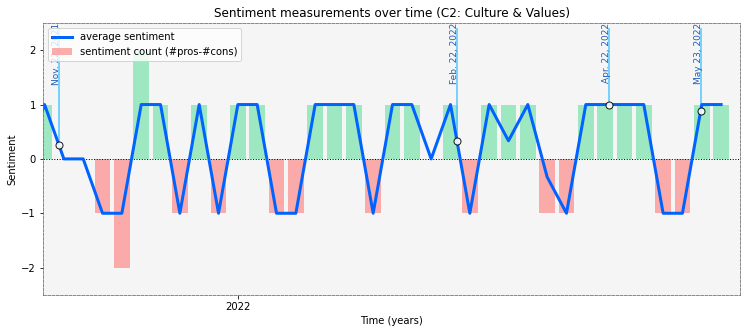

In [77]:
plot_histogram_trimmed(sony_counts_df_2, sony_event_timeline, sony_event_labels, "C2: Culture & Values")

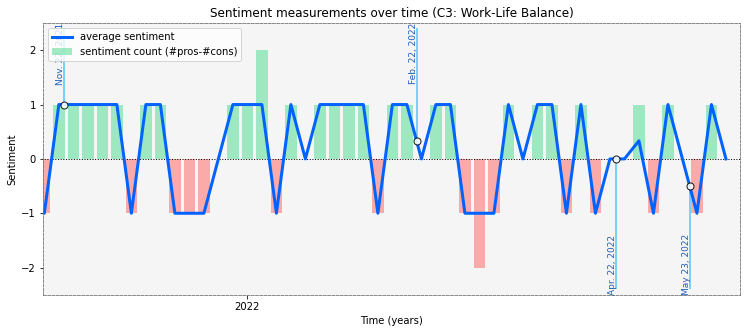

In [78]:
plot_histogram_trimmed(sony_counts_df_3, sony_event_timeline, sony_event_labels, "C3: Work-Life Balance")

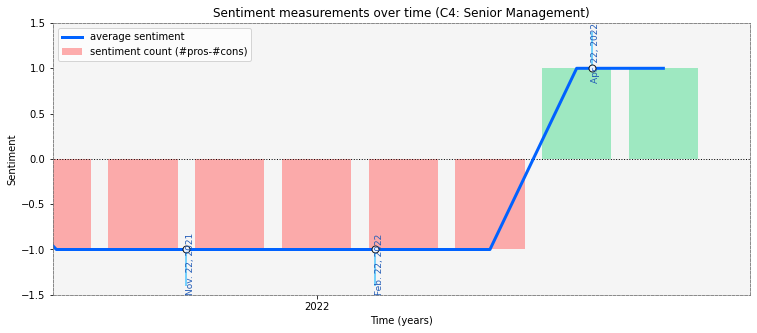

In [79]:
plot_histogram_trimmed(sony_counts_df_4, sony_event_timeline, sony_event_labels, "C4: Senior Management")

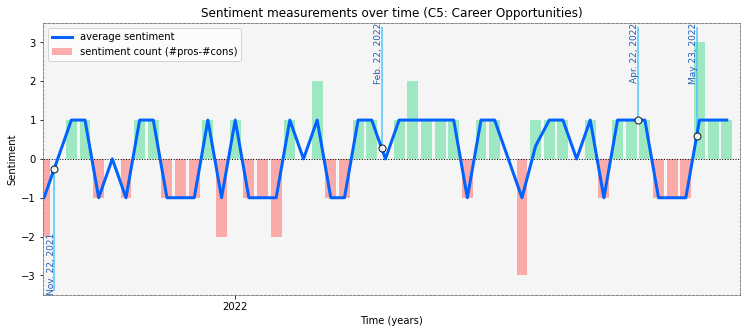

In [80]:
plot_histogram_trimmed(sony_counts_df_5, sony_event_timeline, sony_event_labels, "C5: Career Opportunities")

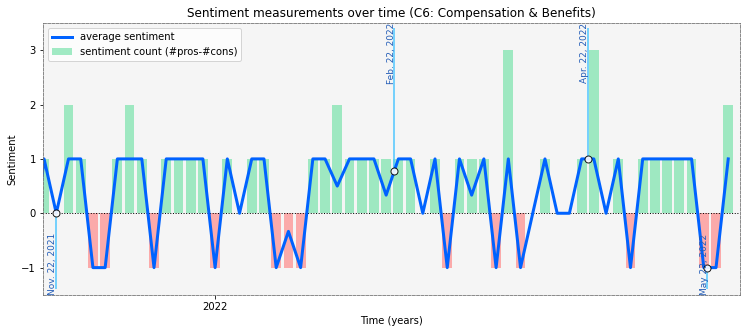

In [81]:
plot_histogram_trimmed(sony_counts_df_6, sony_event_timeline, sony_event_labels, "C6: Compensation & Benefits")

## Pt. 2: Plotting neutral classification data (generated via our fine-tuned BERT Classifier) over time

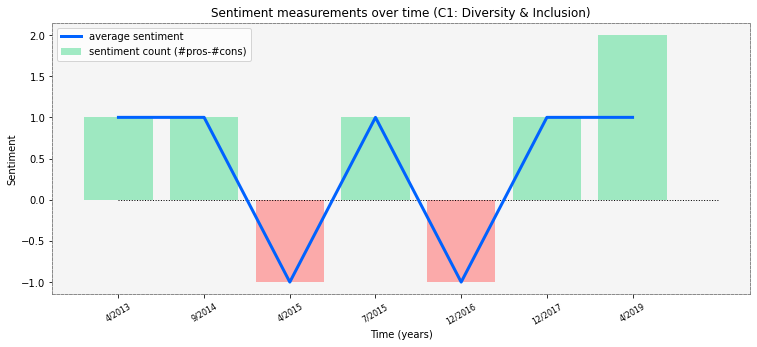

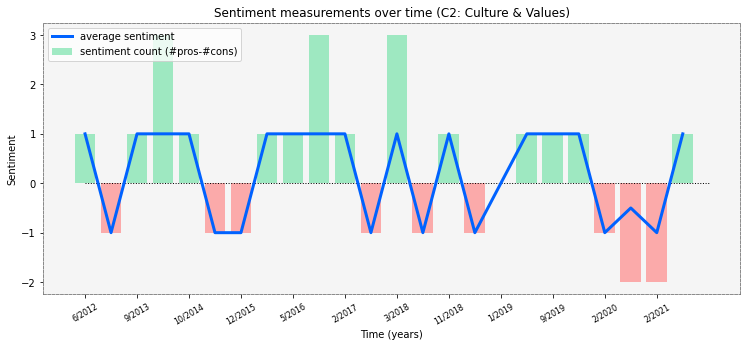

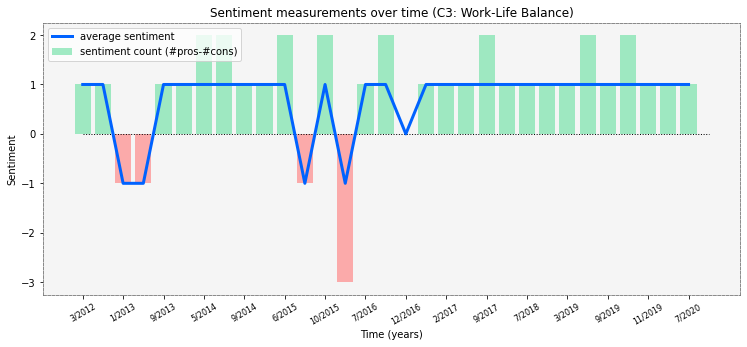

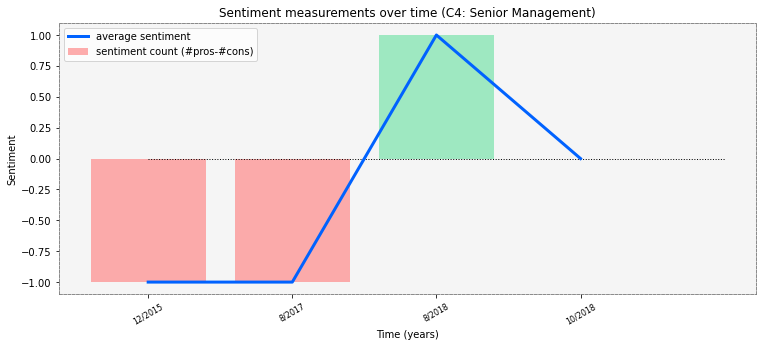

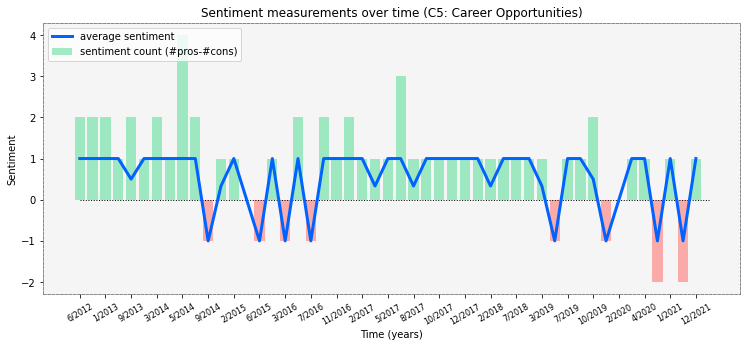

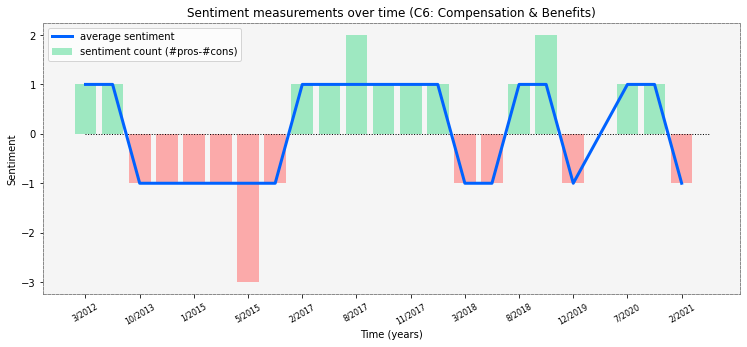

In [103]:
plot_all_categories_no_events(sony_category_dfs)

# Company 3: Ubisoft

In [104]:
ubisoft_event_timeline = ["6/24/2020", "7/6/2020", "7/12/2020", "8/3/2020", "7/16/2021"]
ubisoft_event_labels = ["June 24, 2020", "July 6, 2020", "July 12, 2020", "Aug. 3, 2020", "July 16, 2021"]

## Pt. 1: Plotting gold-label classification data over time

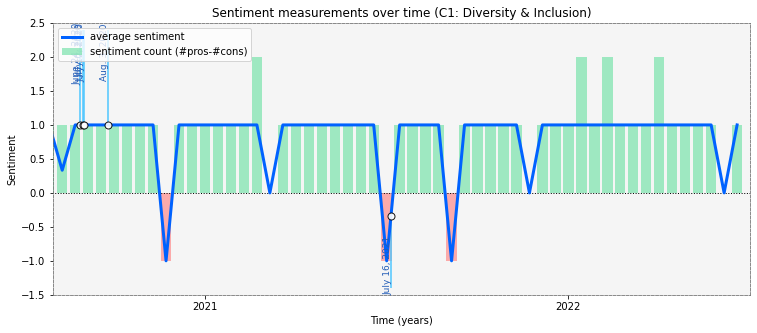

In [105]:
plot_histogram_trimmed(ubisoft_counts_df_1, ubisoft_event_timeline, ubisoft_event_labels, "C1: Diversity & Inclusion")

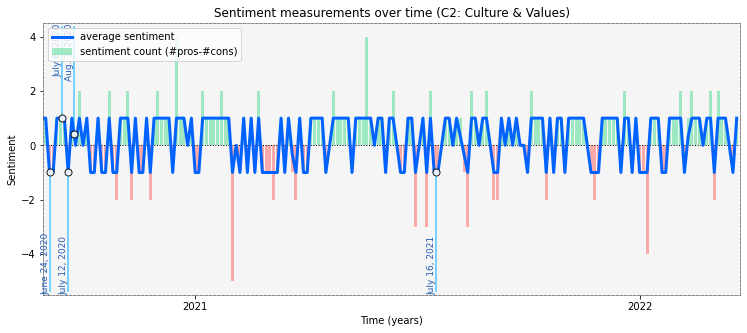

In [106]:
plot_histogram_trimmed(ubisoft_counts_df_2, ubisoft_event_timeline, ubisoft_event_labels, "C2: Culture & Values")

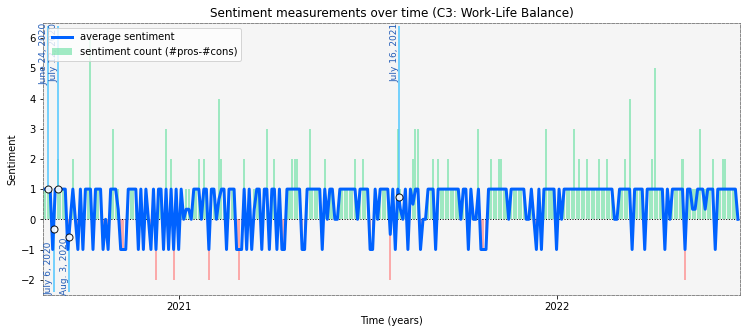

In [107]:
plot_histogram_trimmed(ubisoft_counts_df_3, ubisoft_event_timeline, ubisoft_event_labels, "C3: Work-Life Balance")

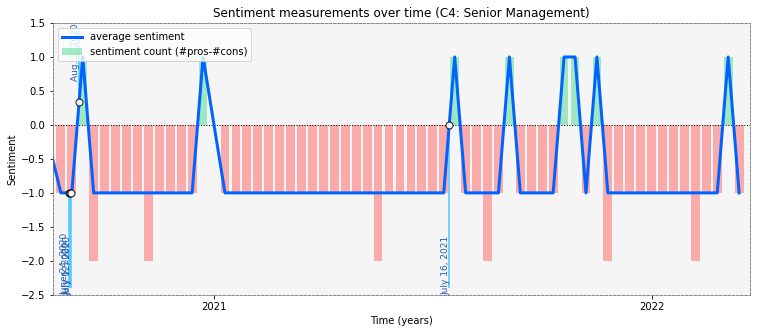

In [108]:
plot_histogram_trimmed(ubisoft_counts_df_4, ubisoft_event_timeline, ubisoft_event_labels, "C4: Senior Management")

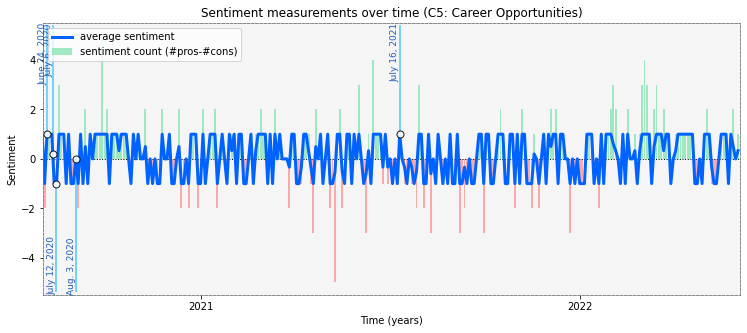

In [109]:
plot_histogram_trimmed(ubisoft_counts_df_5, ubisoft_event_timeline, ubisoft_event_labels, "C5: Career Opportunities")

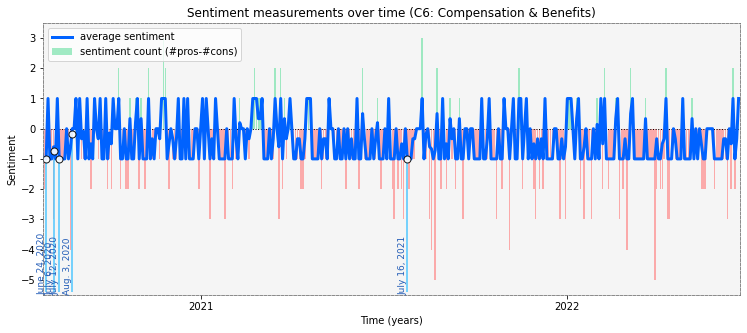

In [110]:
plot_histogram_trimmed(ubisoft_counts_df_6, ubisoft_event_timeline, ubisoft_event_labels, "C6: Compensation & Benefits")

## Pt. 2: Plotting neutral classification data (generated via our fine-tuned BERT Classifier) over time

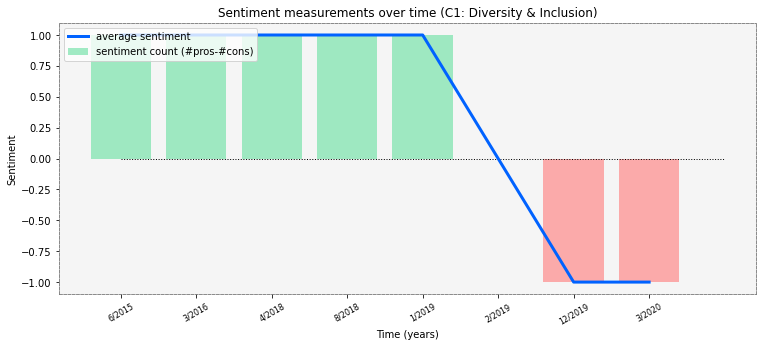

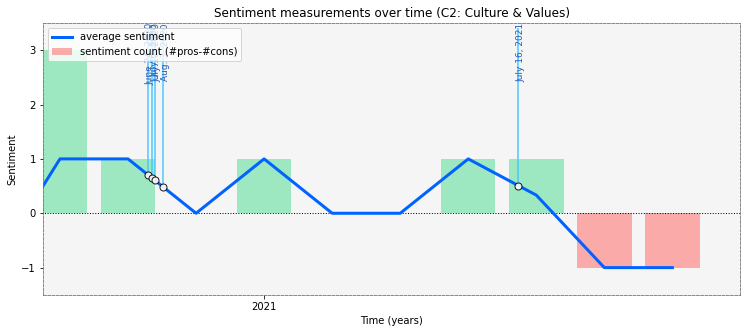

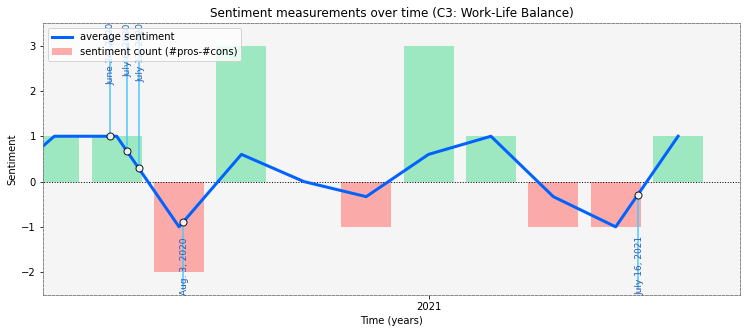

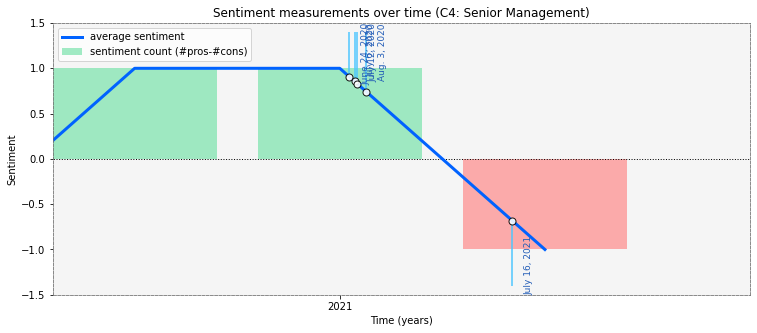

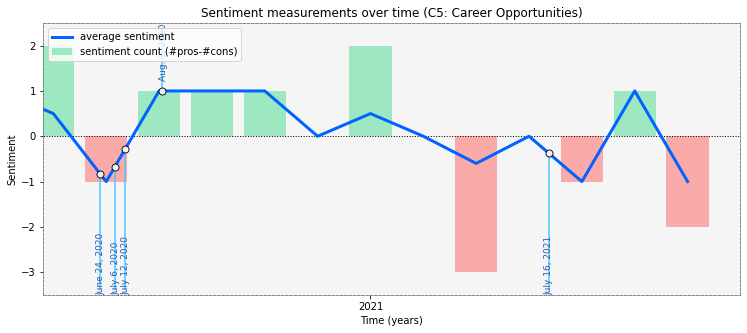

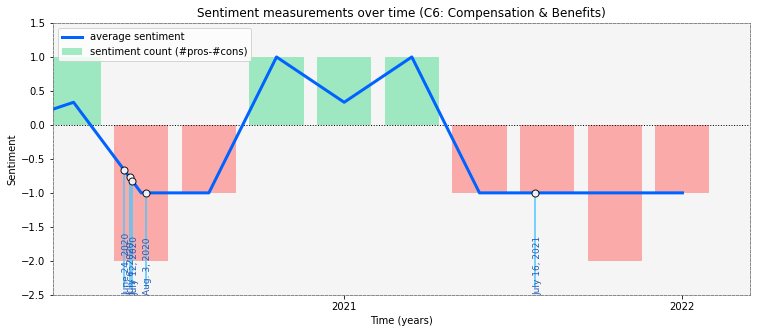

In [115]:
plot_all_categories(ubisoft_category_dfs, ubisoft_event_timeline, ubisoft_event_labels)

# Company 4: Activision

### Timeline

*   Nov. 8, 2013
*   June 1, 2020
*   July 20, 2021
*   July 28, 2021
*   August 3, 2021


In [51]:
activision_event_timeline = ['11/08/2013', '06/01/2020', '07/20/2021', '07/28/2021', '08/03/2021']
activision_event_labels = ["Nov. 8, 2013", "June 1, 2020", "July 20, 2021", "July 28, 2021", "August 3, 2021"]

## Pt. 1: Plotting gold-label classification data over time

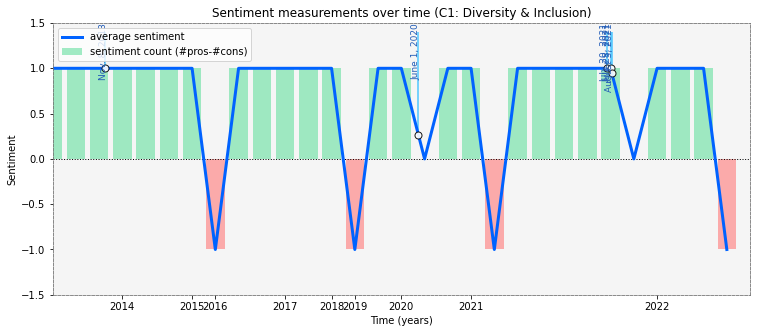

In [59]:
plot_histogram_trimmed(activision_counts_df_1, activision_event_timeline, activision_event_labels, "C1: Diversity & Inclusion")

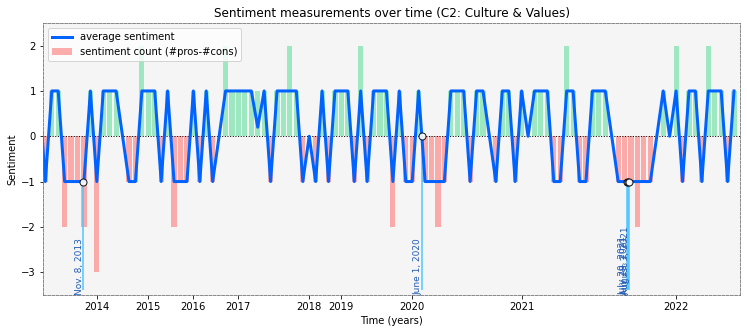

In [60]:
plot_histogram_trimmed(activision_counts_df_2, activision_event_timeline, activision_event_labels, "C2: Culture & Values")

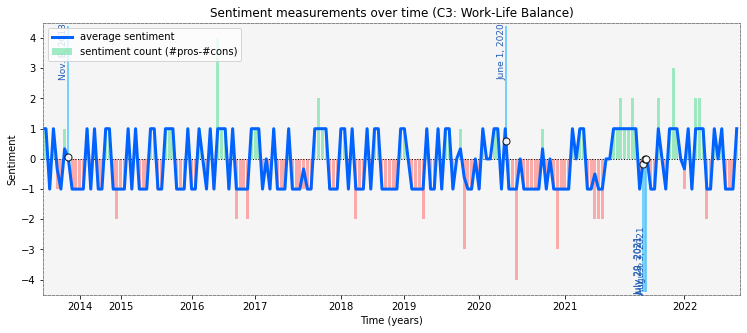

In [61]:
plot_histogram_trimmed(activision_counts_df_3, activision_event_timeline, activision_event_labels, "C3: Work-Life Balance")

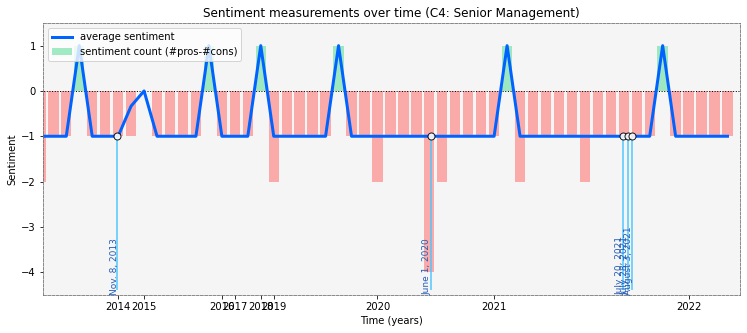

In [62]:
plot_histogram_trimmed(activision_counts_df_4, activision_event_timeline, activision_event_labels, "C4: Senior Management")

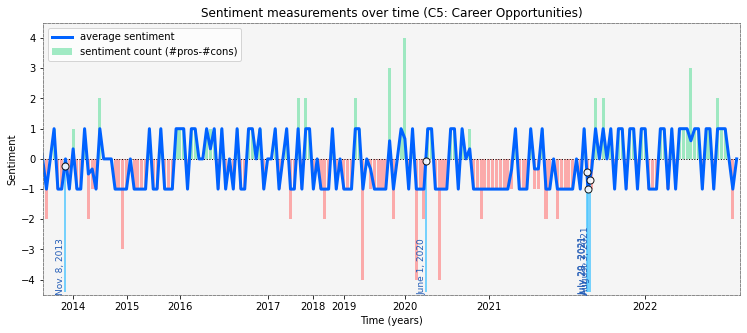

In [65]:
plot_histogram_trimmed(activision_counts_df_5, activision_event_timeline, activision_event_labels, "C5: Career Opportunities")

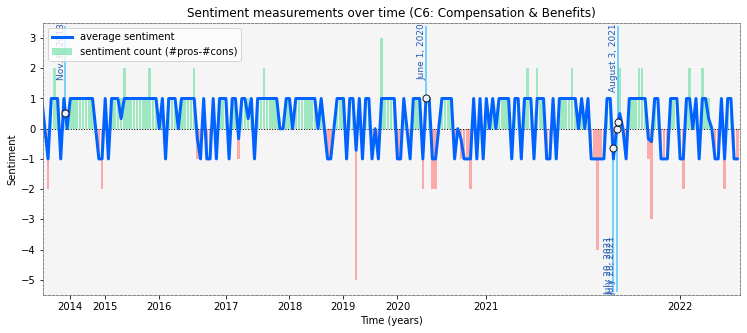

In [66]:
plot_histogram_trimmed(activision_counts_df_6, activision_event_timeline, activision_event_labels, "C6: Compensation & Benefits")

## Pt. 2: Plotting neutral classification data (generated via our fine-tuned BERT Classifier) over time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in long_scalars


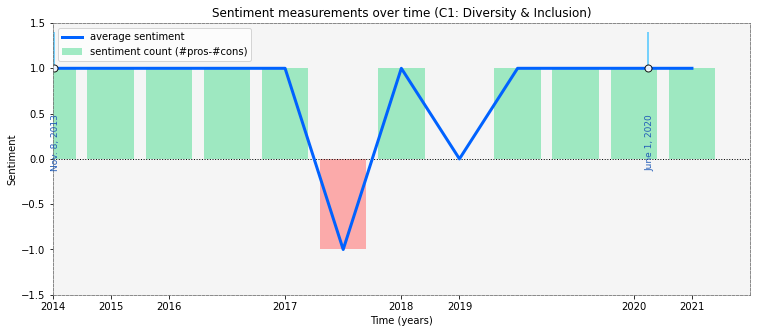

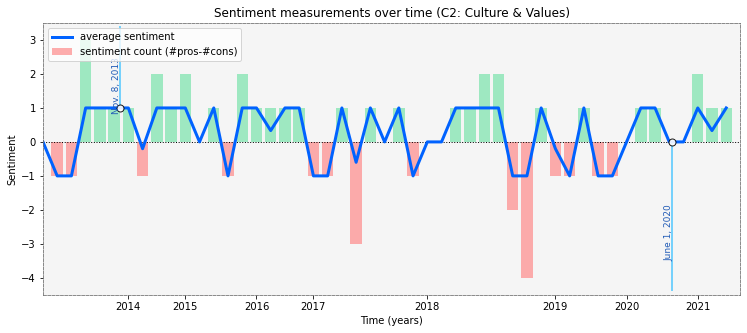

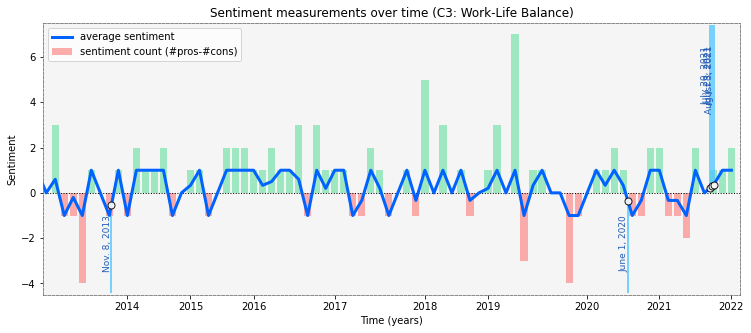

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in long_scalars


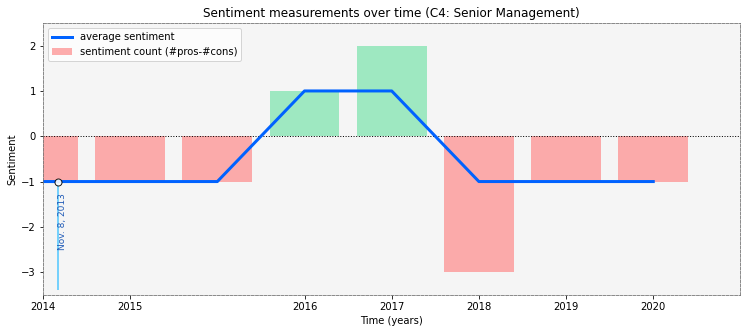

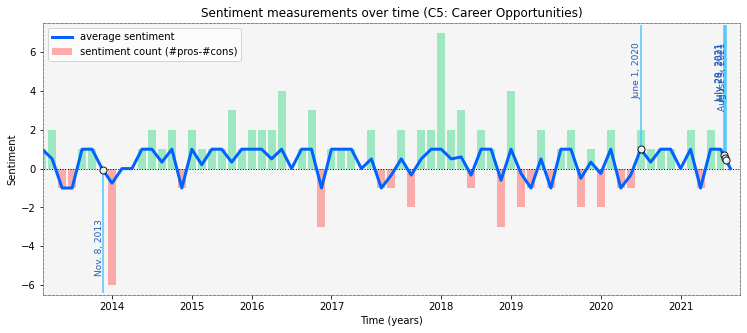

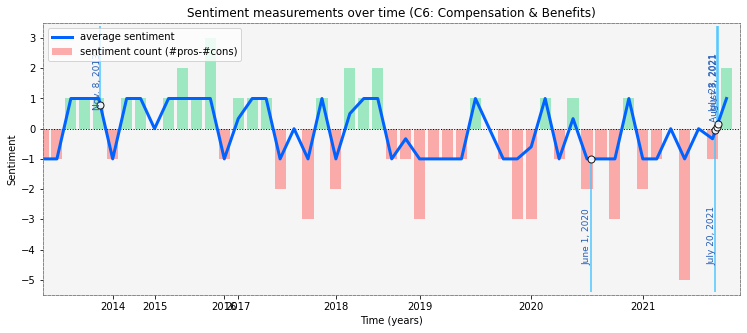

In [69]:
plot_all_categories(activision_category_dfs, activision_event_timeline, activision_event_labels)